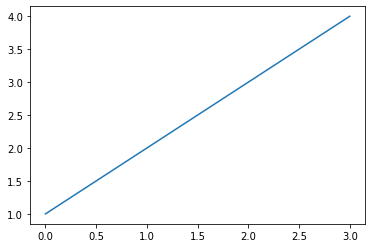

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])

In [2]:
import random
import gym
import sys
import numpy as np
from collections import deque,namedtuple
import os

import torch
import torch.nn as nn
from torch.optim import Adam

ModuleNotFoundError: No module named 'gym'

In [ ]:
env = gym.make('LunarLander-v2')

In [4]:
state_sz = env.observation_space.shape[0]
action_sz = env.action_space.n
print('State space: ',state_sz)
print('Action space: ',action_sz)

State space:  8
Action space:  4


In [5]:
n_episodes=250
batch_size=128
gamma = 0.995
lr = 0.0001
eps = 1.0
decay = 0.99

In [6]:
class D3QN(nn.Module):
    def __init__(self,hidden_sz):
        super().__init__()
        self.hidden_sz = hidden_sz
        
        self.fc1 = nn.Linear(state_sz,self.hidden_sz)
        self.fc2 = nn.Linear(self.hidden_sz,self.hidden_sz)
        self.A = nn.Linear(self.hidden_sz,action_sz)
        self.V = nn.Linear(self.hidden_sz,1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        A = self.A(x) - self.A(x).mean(dim=1,keepdim=True)
        V = self.V(x)
        
        return V+A

In [7]:
replay_buffer = deque(maxlen=10000)

In [8]:
transition = namedtuple('transition',['s_prime','reward','s','action','done'])

In [9]:
def store(transition):
    replay_buffer.append(transition)

In [10]:
d3q_network = D3QN(256)
target_network = D3QN(256)

In [11]:
optimizer = Adam(d3q_network.parameters(),lr=lr)
loss_fn = nn.MSELoss()

In [12]:
def update():
    
    if len(replay_buffer)<batch_size:
        return
    
    batch = random.sample(replay_buffer,batch_size)
    
    s = torch.FloatTensor(np.array([t.s for t in batch]))
    r = torch.FloatTensor(np.array([t.reward for t in batch]))
    s_prime = torch.FloatTensor(np.array([t.s_prime for t in batch]))
    a = torch.LongTensor(np.array([t.action for t in batch])).unsqueeze(1)
    done = torch.FloatTensor(np.array([t.done for t in batch]))
    
    q_pred = d3q_network(s)
    q_target = target_network(s_prime)
    
    target = (r + gamma*q_target.max(dim=1)[0]*(1-done))
    
    prediction = q_pred.gather(1,a)
    
    
    optimizer.zero_grad()
    
    loss = loss_fn(target.unsqueeze(1),prediction)
    
    loss.backward()
    
    optimizer.step() 
    
    

In [13]:
class Agent():
    def __init__(self,target_update_frequency=100,eps=1):
        
        self.eps = eps
        self.target_update_frequency = target_update_frequency
        self.target_update_counter = 0
        self.rewards = []
        
    def select_action(self,state,eps):
        
        t = np.random.random()
        if t < eps:
            a = np.random.choice(range(action_sz))
        else:
            q = d3q_network(torch.FloatTensor(state).unsqueeze(0))
            a = q.argmax().item()   
        return a
            
        
        
    def run_episode(self,render):

        s = env.reset()
        done = False
        total_reward = 0.0
        self.eps = self.eps * decay
        transition_count = 0
        
        while not done:
            if render:
                env.render()
                
            eps = 0.0
            
            self.target_update_counter += 1
            
            if self.eps > 0.01:
                eps = self.eps
            else:
                eps = 0.01
            
            action = self.select_action(s,eps)
            
            s_prime,reward,done,_ = env.step(action)
            
            store(transition(s_prime,reward,s,action,done))
            
            total_reward += reward
            
            s = s_prime
            
            done = done
            
            update()
            
            transition_count+=1
            
        print('Transition Count: ',transition_count)    
        print('Episode Reward: ',total_reward)    
        self.rewards.append(total_reward)
            
    def train(self):
        
        for k in range(n_episodes):
            
            render = False
            
            if k % 100 <= 10:
                render = True
            
            print('Episode: ',k)
            self.run_episode(render)
            
                      
            if self.target_update_counter >= self.target_update_frequency:

                self.target_update_counter = 0
                target_network.load_state_dict(d3q_network.state_dict())    

In [14]:
agent = Agent()

In [15]:
%%time
agent.train()

Episode:  0
Transition Count:  72
Episode Reward:  -114.18913640783421
Episode:  1
Transition Count:  62
Episode Reward:  -114.47665157555667
Episode:  2
Transition Count:  131
Episode Reward:  -276.0280024697678
Episode:  3
Transition Count:  85
Episode Reward:  -101.73536706738611
Episode:  4
Transition Count:  77
Episode Reward:  -57.81187506342341
Episode:  5
Transition Count:  88
Episode Reward:  -169.34193698141706
Episode:  6
Transition Count:  112
Episode Reward:  -152.23415638735867
Episode:  7
Transition Count:  73
Episode Reward:  -48.925321572538984
Episode:  8
Transition Count:  67
Episode Reward:  -76.36703405976154
Episode:  9
Transition Count:  81
Episode Reward:  -193.65670891058596
Episode:  10
Transition Count:  92
Episode Reward:  -382.3411580478361
Episode:  11
Transition Count:  120
Episode Reward:  -412.0650810298767
Episode:  12
Transition Count:  81
Episode Reward:  -300.460051399853
Episode:  13
Transition Count:  119
Episode Reward:  -277.57381991842703
Episo

Transition Count:  1000
Episode Reward:  0.0032783310046788916
Episode:  115
Transition Count:  143
Episode Reward:  -29.502871710758043
Episode:  116
Transition Count:  1000
Episode Reward:  19.260967414452583
Episode:  117
Transition Count:  1000
Episode Reward:  43.24413666166272
Episode:  118
Transition Count:  1000
Episode Reward:  -25.28659822287351
Episode:  119
Transition Count:  1000
Episode Reward:  48.58014750630994
Episode:  120
Transition Count:  1000
Episode Reward:  72.2914226305962
Episode:  121
Transition Count:  1000
Episode Reward:  90.00481919409727
Episode:  122
Transition Count:  1000
Episode Reward:  101.21264934500898
Episode:  123
Transition Count:  781
Episode Reward:  153.08627991466045
Episode:  124
Transition Count:  1000
Episode Reward:  96.3499494104592
Episode:  125
Transition Count:  1000
Episode Reward:  -76.67022486683562
Episode:  126
Transition Count:  1000
Episode Reward:  76.95133047676589
Episode:  127
Transition Count:  1000
Episode Reward:  117

Transition Count:  258
Episode Reward:  300.6903322601129
Episode:  228
Transition Count:  350
Episode Reward:  254.539599889318
Episode:  229
Transition Count:  679
Episode Reward:  217.41523424122607
Episode:  230
Transition Count:  352
Episode Reward:  252.58723909986276
Episode:  231
Transition Count:  443
Episode Reward:  265.3626532730726
Episode:  232
Transition Count:  278
Episode Reward:  221.35904762455368
Episode:  233
Transition Count:  300
Episode Reward:  261.8731083734566
Episode:  234
Transition Count:  533
Episode Reward:  256.35238954514165
Episode:  235
Transition Count:  286
Episode Reward:  254.58228713844738
Episode:  236
Transition Count:  313
Episode Reward:  260.40588934031064
Episode:  237
Transition Count:  243
Episode Reward:  267.19505018803704
Episode:  238
Transition Count:  451
Episode Reward:  248.26739490166028
Episode:  239
Transition Count:  1000
Episode Reward:  83.99508674695008
Episode:  240
Transition Count:  450
Episode Reward:  291.690684640112

In [ ]:
print(np.mean(agent.rewards))
print(np.std(agent.rewards))

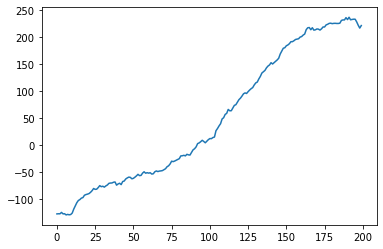

In [16]:
plt.plot([np.mean(agent.rewards[i-50:i]) for i in range(50,250)]);

In [ ]:
print(np.max(agent.rewards))